# Healthcare Final Project
- Darshil Desai, Edwin Ramirez, Rashi Saxena

(D)

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing

from scipy.stats import chi2_contingency
import seaborn as sns

# 1. Project Overview

- Regression: Predict post_index_cost  ? which one is it
- Classifications - Logistic, KNN and NB: to predict pdc_80_flag

# 2. Exploring the Dataset

In [5]:
# Reading in the data file
data = pd.read_csv('projectTrain.csv')
data.head()

,pdc,num_ip_post,total_los_post,num_op_post,num_er_post,num_ndc_post,num_gpi6_post,adjust_total_30d_post,generic_rate_post,post_ip_flag,...,generic_cost,brand_cost,ratio_G_total_cost,numofgen_post,numofbrand_post,generic_cost_post,brand_cost_post,ratio_G_total_cost_post,pdc_80_flag,drug_class
0,0.333333,0,0,4,0,15,5,14.466667,0.101382,0,...,30.621563,2984.927229,0.010155,2,13,196.359216,3001.501507,0.061403,0,*ANTIDIABETICS*
1,0.866667,0,0,5,0,16,4,18.000000,0.888889,0,...,720.788173,0.000000,1.000000,14,2,671.755173,735.661568,0.477297,1,*ANTIDIABETICS*
2,0.938889,0,0,7,0,11,4,8.600000,1.000000,0,...,179.538533,0.000000,1.000000,11,0,171.446621,0.000000,1.000000,1,*ANTICOAGULANTS*
3,0.077778,1,12,40,0,5,5,2.033333,1.000000,1,...,105.816329,0.000000,1.000000,5,0,335.826436,0.000000,1.000000,0,*ANTICOAGULANTS*
4,0.444444,0,0,12,1,15,9,14.833333,0.528090,0,...,630.173638,3265.595950,0.161758,8,7,75.988845,2054.400835,0.035669,0,*ANTIDIABETICS*


In [17]:
# Taking a look at the data dimensions
print ('This dataset has {} records and {} features'.format(data.shape[0], data.shape[1]))

This dataset has 2000 records and 94 features


In [16]:
# Features in focus
print ('Predictor variable for the regression problem: post_ip_cost & for the classification problem: pdc_80_flag' )

Predictor variable for the regression problem: post_ip_cost & for the classification problem: pdc_80_flag


### Taking a look at our predictor variables

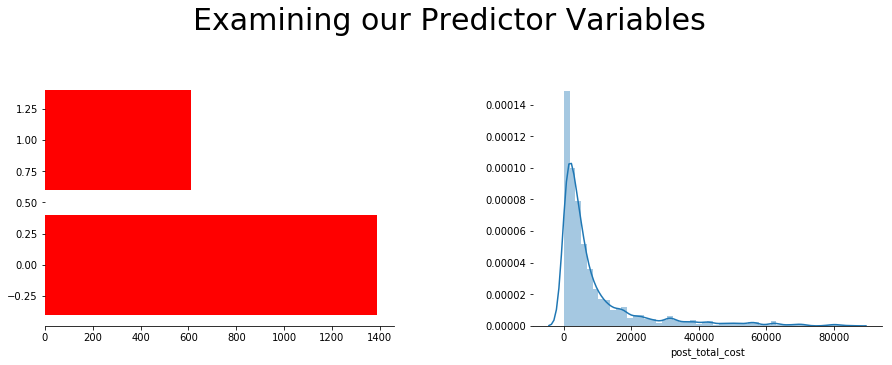

In [54]:
# Taking a look at our predictor variables

plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.suptitle('Examining our Predictor Variables', fontsize=30)

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
plt.subplot(2,2,1)

a = pd.DataFrame(data.groupby(data.pdc_80_flag)['pdc_80_flag'].count())
plt.barh(list(a.index),a.pdc_80_flag, color = 'red')

#-------------------------------------------
# Plotting the predictor variable to convey class balance or imbalance
plt.subplot(2,2,2)
sns.distplot(data['post_total_cost'], label="Actual High")


sns.despine(left=True)


### Subsetting our independant variables

In this section we will subset the dataframe and select the features we deem appropriate to further this analysis. Note that these features are not final and among these features there will be several that will not be selected for the machine learning models. In the "Feature Selection" section of this project, we will employ the use of various statistical techniques to determine the appropriateness of the same. 

##### Continuous variables 
- num_ip
- num_op
- num_er
- num_ndc
- generic_rate_post

##### Categorical variables 
- All diseases
- Age group
- sex

In [203]:
"""Creating the Continous variables"""
cont_features = data[['num_ip', 'num_op','num_er','num_ndc','generic_rate_post']] 
cont_features.head()

,num_ip,num_op,num_er,num_ndc,generic_rate_post
0,0,27,0,15,0.101382
1,0,3,0,17,0.888889
2,1,8,0,12,1.000000
3,2,8,1,6,1.000000
4,0,7,0,20,0.528090


In [204]:
"""Creating our categorical variables"""

all_diseases = data.iloc[:,26:58]
othercats = data.iloc[:,19:22]

cat_features = pd.concat([all_diseases,othercats ],axis=1)
cat_features.head(2)

,ALCOHOL_DRUG,ASTHMA,CARDIAC_ARRYTHMIA,CARDIAC_VALVULAR,CEREBROVASCULAR,CHRONIC_KIDNEY,CHRONIC_PAIN_FIBRO,CHF,COPD,DEMENTIA,...,SCHIZOPHRENIA,SLEEP_DISORDERS,SMOKING,THYROID,Solid_Tumor,Metastatic,Leukemia_Lymphoma,age_grpN,sexN,regionN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,3
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2,1,3


#### Examining our independant variables

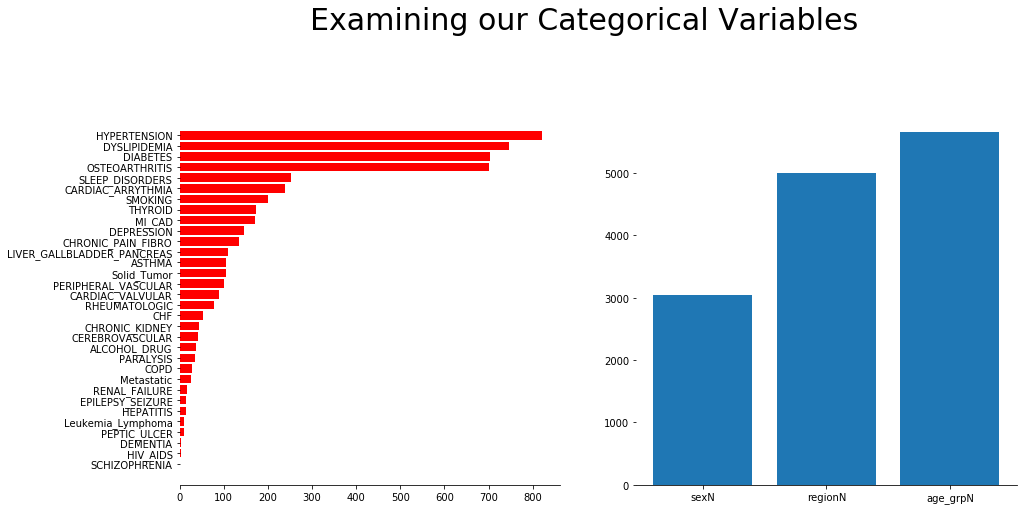

In [249]:

plt.figure(figsize=(15,15))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.suptitle('Examining our Categorical Variables', fontsize=30)

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
# Taking a look at our categorical variables
plt.subplot(2,2,1)

z = pd.DataFrame(all_diseases.sum())
z.columns = ['counts']
z = z.sort_values('counts',ascending=True)
plt.barh(z.index, z.counts, color = 'red')

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
# Taking a look at our categorical variables
plt.subplot(2,2,2)

z1 = pd.DataFrame(othercats.sum())
z1.columns = ['counts']
z1 = z1.sort_values('counts',ascending=True)
plt.bar(z1.index, z1.counts)


sns.despine(left=True)


In [41]:
data.columns

Index(['pdc', 'num_ip_post', 'total_los_post', 'num_op_post', 'num_er_post',
       'num_ndc_post', 'num_gpi6_post', 'adjust_total_30d_post',
       'generic_rate_post', 'post_ip_flag', 'post_er_flag', 'pdc_cat',
       'post_ip_cost', 'post_er_cost', 'post_rx_cost', 'post_op_cost',
       'post_total_cost', 'post_medical_cost', 'idx_copay', 'age_grpN', 'sexN',
       'regionN', 'idx_prodtypeN', 'idx_paytypN', 'age_cat', 'log_idx_copay',
       'ALCOHOL_DRUG', 'ASTHMA', 'CARDIAC_ARRYTHMIA', 'CARDIAC_VALVULAR',
       'CEREBROVASCULAR', 'CHRONIC_KIDNEY', 'CHRONIC_PAIN_FIBRO', 'CHF',
       'COPD', 'DEMENTIA', 'DEPRESSION', 'DIABETES', 'DYSLIPIDEMIA',
       'EPILEPSY_SEIZURE', 'HEPATITIS', 'HIV_AIDS', 'HYPERTENSION',
       'LIVER_GALLBLADDER_PANCREAS', 'MI_CAD', 'OSTEOARTHRITIS', 'PARALYSIS',
       'PEPTIC_ULCER', 'PERIPHERAL_VASCULAR', 'RENAL_FAILURE', 'RHEUMATOLOGIC',
       'SCHIZOPHRENIA', 'SLEEP_DISORDERS', 'SMOKING', 'THYROID', 'Solid_Tumor',
       'Metastatic', 'Leukemia_Lymph

# 3. Data Cleaning & Feature Engineering

- **a.** Normalize the continuous variables
- **b.** Deal with outlier data? Cap it maybe
- **c.** Create new features if necessary

### (3.a) Normalizing the data

Here we look to employ the use of Guassian normalization techniques to pull our continuous variables, considering that they are not on the same scale

In [182]:
# Normalizing the continous features
scaler = preprocessing.StandardScaler().fit(cont_features)
X_scaled = scaler.transform(cont_features)

C:\Users\Darshil Desai\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Darshil Desai\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


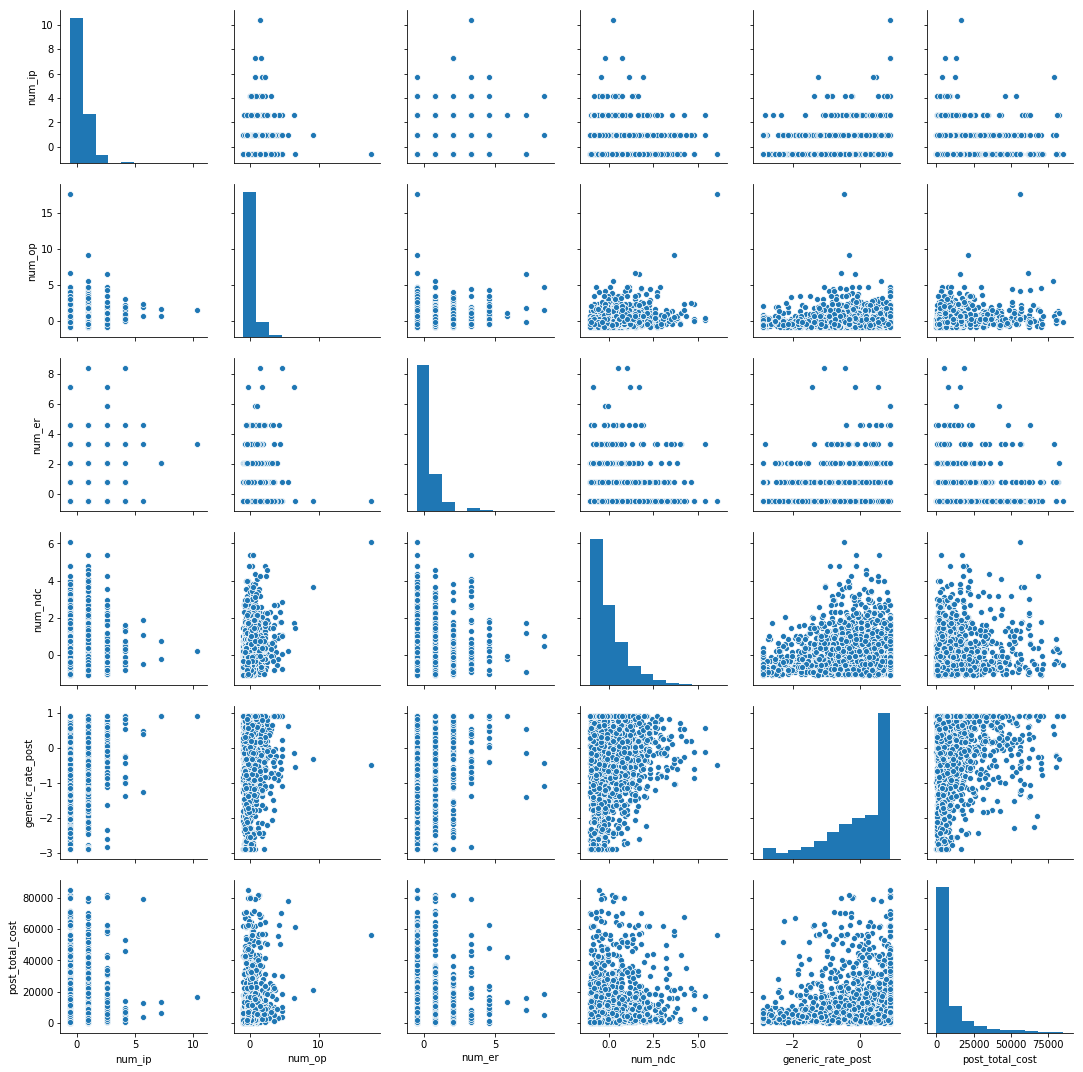

In [188]:
num_df = pd.concat([pd.DataFrame(X_scaled, columns =cont_features.columns ), data['post_total_cost']], axis=1)

num_df.head(2)
ax = sns.pairplot(num_df)

# 4. Feature Selection

### a. Determining the R-square or correlation co-efficient

### b. Determining Associativity

This section will focus on determining the appropriate features to incorporate in our model fitting methods. We will employ the use of various techniques to determine the following: 

- **(i)** Which features work best in creating a near optimal regression model, therefore allowing us to predict the post_index_cost variable       
    
    
- **(ii)** Which features show significant associativity which the predictor variable we will use for classification. Predicting the pdc_80_flag variable poses as a binary classification problem. 
    - Employ the use of chi-square tests to determine which categorical variables prove to be associative with 
    - Employ the use of the ________ to determine which continuous variables work best in predicting the pdc_80_flag


#### (b.i) Chi - Square test

In [258]:
"""Co - morbidity index"""
# First we need to make a contigency table 


def chisq(cat_cols, group, a, df):    
    """
    Calculates the chi-square metric for a set of categorical variables given the group
    
    Parameters
    ----------
    : param cat_cols: The column names of categorica columns in from the data file
    : param group: Aither ANTIDIABETIC or ANTICOAGULANT or BOTH as 'ANTIDIABETIC|ANTICOAGULANT'
    : param a: alpha test statistic
    """
    
    data = df
    
    # Only retreiving rows belonging to the group
    subset_ad = data[data['drug_class'].str.contains(group)]
    
    # Initializing empty lists to append into
    var = []
    p_val = []
    

    # Iterating over each cat_column
    for x in cat_cols:
        
        # Contingency table for that categorical column and the pdc_80_flag
        table = np.array(pd.crosstab(subset_ad[x], subset_ad['pdc_80_flag']))

        # Getting statistical metrics
        stat, p, dof, expected = chi2_contingency(table)
        
        # Append all data
        var.append(x), p_val.append(p)
    
    # Empty dataframe to append into
    mod_df = pd.DataFrame({'variable': var, 'p_val': np.round(p_val,6)})

    # return
    return mod_df[mod_df['p_val'] <= a]          


In [259]:
# Which categorical columns were chosen!
cat_chosen = chisq(cat_features.columns, 'ANTIDIABETIC|ANTICOAGULANT', 0.05, df=data).variable
cat_chosen

1                 ASTHMA
5         CHRONIC_KIDNEY
6     CHRONIC_PAIN_FIBRO
10            DEPRESSION
11              DIABETES
12          DYSLIPIDEMIA
16          HYPERTENSION
19        OSTEOARTHRITIS
27               SMOKING
32              age_grpN
33                  sexN
Name: variable, dtype: object

#### b.i Statistical test to choose continous features

# 5. Model Fitting 